<a href="https://colab.research.google.com/github/saffarizadeh/BUAN4061/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://saffarizadeh.com/Logo.png" width="300px"/>

# *BUAN 4061: Advanced Business Analytics*

# **Assignment 4: Predicting Stock Price**

Instructor: Dr. Kambiz Saffarizadeh

---
Disclaimer: The predictions provided by this Notebook are only for educational purposes. I don't take responsibility for any trading decision that may be made based on these predictions.
---

# Assingment description

*   Go through this Notebook and add explanations to each piece of code such that a person who is not familiar with Python and TensorFlow can understand what is going on.
*   Create and train `model3` and then plot a figure inidcating predictions from `model1`, `model2`, and `model3`.
*   Save this Notebook and submit the .ipynb file.

# Yahoo Finance

In [ ]:
!pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime
import tensorflow as tf

In [4]:
plt.style.use("fivethirtyeight")

# Download the dataset

In [5]:
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

In [6]:
company_data = yf.download('AAPL', start, end)

[*********************100%***********************]  1 of 1 completed


In [7]:
company_data['company_name'] = 'AAPL'

# Explore the dataset

In [8]:
company_data.head()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2012-04-24,20.093214,20.274643,19.821428,20.010000,17.134048,1076149200,AAPL
2012-04-25,21.987143,22.071428,21.642857,21.785713,18.654545,905777600,AAPL
2012-04-26,21.938213,21.953215,21.504642,21.703571,18.584206,536068400,AAPL
2012-04-27,21.609644,21.649286,21.446428,21.535713,18.440475,406722400,AAPL
2012-04-30,21.350000,21.371429,20.821428,20.856428,17.858820,506144800,AAPL


In [9]:
company_data.shape

(2517, 7)

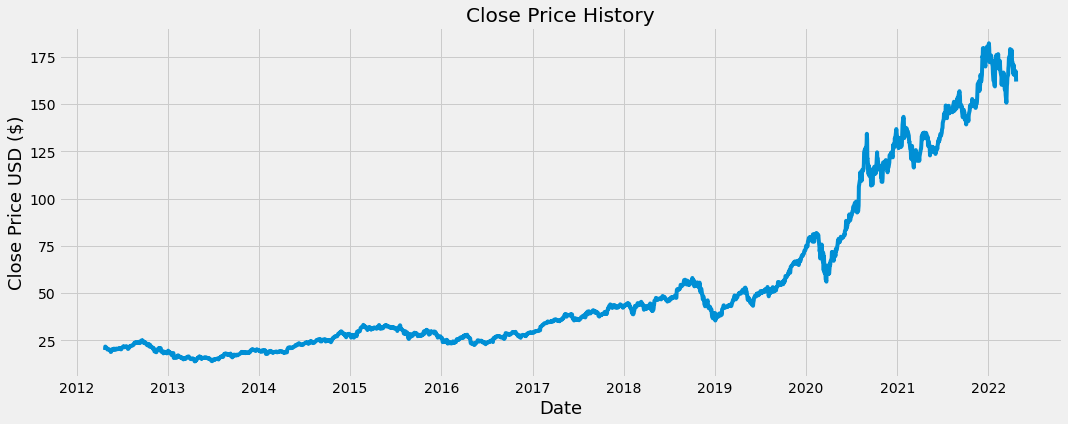

In [10]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(company_data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# Create a useful dataset to train our model

Standardize or normalize data in the close price column.

In [11]:
dataset = (company_data['Close'] - company_data['Close'].min()) / (company_data['Close'].max() - company_data['Close'].min())

In [12]:
dataset.shape

(2517,)

Let's create a dataset to predict the price of stock at time `t` based on the prices in the previous `60` days.

In [13]:
window = 60

In [14]:
x_data = []
y_data = []

for t in range(60, len(dataset)):
    x_data.append(dataset[t-window:t])
    y_data.append(dataset[t])

In [ ]:
x_data[0]

In [34]:
y_data[0]

0.04755671596755667


In [19]:
x_train = x_data[: int(len(dataset)*0.8)]
y_train = y_data[: int(len(dataset)*0.8)]
x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation = x_data[int(len(dataset)*0.8)-window:]
y_validation = y_data[int(len(dataset)*0.8)-window:]
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

In [20]:
x_train.shape

(2013, 60)

In [21]:
x_train = x_train[:, :, np.newaxis]
x_validation = x_validation[:, :, np.newaxis]

In [22]:
x_train.shape

(2013, 60, 1)

In [23]:
x_validation.shape

(504, 60, 1)

# Create the model

In [24]:
model1 = tf.keras.Sequential([
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(25),
  tf.keras.layers.Dense(1)
])

In [25]:
model1.compile(
    optimizer='adam',
    loss='mse'
)

In [26]:
history1 = model1.fit(x_train, y_train, epochs=5, validation_data=(x_validation, y_validation))

Epoch 1/5
63/63 [==============================] - 3s 5ms/step - loss: 0.0147 - val_loss: 0.2633
Epoch 2/5
63/63 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.1141
Epoch 3/5
63/63 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0308
Epoch 4/5
63/63 [==============================] - 0s 3ms/step - loss: 8.6743e-04 - val_loss: 0.0056
Epoch 5/5
63/63 [==============================] - 0s 3ms/step - loss: 4.9676e-04 - val_loss: 0.0031


In [27]:
model2 = tf.keras.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(25),
  tf.keras.layers.Dense(1)
])

In [28]:
model2.compile(
    optimizer='adam',
    loss='mse'
)

In [29]:
history2 = model2.fit(x_train, y_train, epochs=1, validation_data=(x_validation, y_validation))

63/63 [==============================] - 6s 20ms/step - loss: 0.0013 - val_loss: 0.0013


# Make predictions

In [30]:
predictions1 = model1.predict(x_validation)
predictions2 = model2.predict(x_validation)

We scaled down the close price values before. Here we convert them back to the origirnal scale.

In [31]:
predictions1 = (predictions1 * (company_data['Close'].max() - company_data['Close'].min())) + company_data['Close'].min()
predictions2 = (predictions2 * (company_data['Close'].max() - company_data['Close'].min())) + company_data['Close'].min()

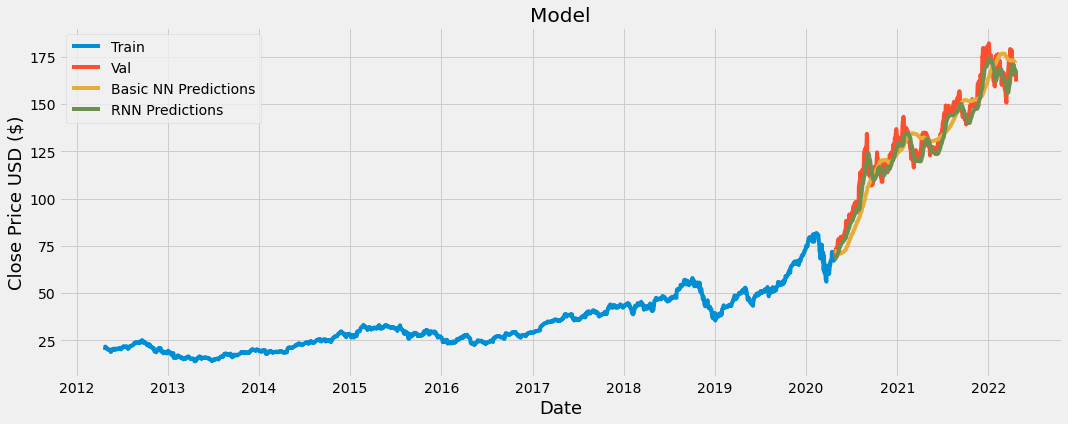

In [32]:
train = company_data[: int(len(company_data)*0.8)]
valid = company_data[int(len(company_data)*0.8): ]
predi1 = pd.Series(predictions1.squeeze(), index=valid.index)
predi2 = pd.Series(predictions2.squeeze(), index=valid.index)

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(predi1)
plt.plot(predi2)

plt.legend(['Train', 'Val', 'Basic NN Predictions', 'RNN Predictions'], loc='upper left')
plt.show()

# Create `model3` using `Conv1D` layers

Use one or more `Conv1D` layers to create a new model to predict the stock price. Note that unlike when we used convolutional layers for images, here we are not dealing with 2-dimensional images. Instead we are dealing with 1-dimensional series, which represent vectors of prices. Thus, why we use `Conv1D` instead of `Conv2D`. You still need to specify the number of filters and kernel size. To specify kernel size, you need to choose a single number instead of choosing a 2-dimensional tuple (remember before we would choose something like (3,3); but here we need a 1-dimensional kernel, so we only need one number like 10).

In [ ]:
# create model3


In [ ]:
# compile model3


In [ ]:
# train model3


When you're finished with `model3`, run the following cell to plot the results.

In [ ]:
predictions1 = model1.predict(x_validation)
predictions2 = model2.predict(x_validation)
predictions3 = model3.predict(x_validation)

predictions1 = (predictions1 * (company_data['Close'].max() - company_data['Close'].min())) + company_data['Close'].min()
predictions2 = (predictions2 * (company_data['Close'].max() - company_data['Close'].min())) + company_data['Close'].min()
predictions3 = (predictions3 * (company_data['Close'].max() - company_data['Close'].min())) + company_data['Close'].min()

train = company_data[: int(len(company_data)*0.8)]
valid = company_data[int(len(company_data)*0.8): ]
predi1 = pd.Series(predictions1.squeeze(), index=valid.index)
predi2 = pd.Series(predictions2.squeeze(), index=valid.index)
predi3 = pd.Series(predictions3.squeeze(), index=valid.index)

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(predi1)
plt.plot(predi2)
plt.plot(predi3)

plt.legend(['Train', 'Val', 'Basic NN Predictions', 'RNN Predictions', 'CNN Predictions'], loc='upper left')
plt.show()